In [42]:
!pip install pyspark
!pip install nltk
!pip install wordcloud

In [80]:
import gdown
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf, split, explode, size, array_remove, array_contains, regexp_replace, lower
from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [44]:
file_id = '1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/mental_health.csv'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

The file '/content/mental_health.csv' already exists.


In [45]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint/')

In [46]:
spark.conf.set("spark.sql.shuffle.partitions", 16)
spark.conf.set("spark.default.parallelism", 16)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

In [47]:
df = spark.read.csv(output_path, header=True, inferSchema=True)

In [48]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [49]:
# Display summary statistics for numerical columns
df.describe().show()

# Display the schema of the DataFrame
df.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL| 0.4999799966498138|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



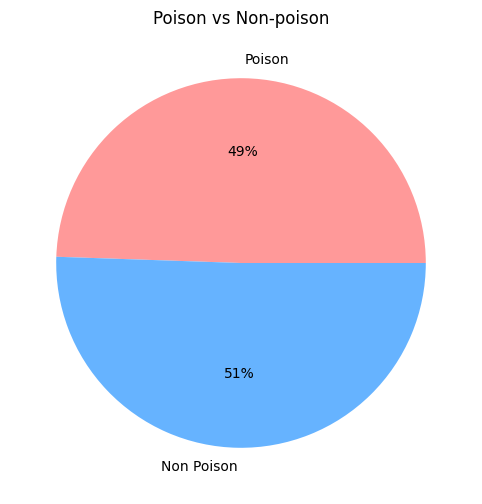

In [50]:
# Assuming 'label' is a boolean column in your DataFrame
sarcastic_counts = df.groupBy("label").count().collect()

# Extract counts
non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

# Prepare data for pie chart
labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

# Display the pie chart
plt.show()


In [51]:
def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
df = df.withColumn('extracted_text', extract_text_udf('text'))


In [52]:
# Show the updated DataFrame
df.show(15)

+--------------------+-----+--------------------+
|                text|label|      extracted_text|
+--------------------+-----+--------------------+
|dear american tee...|    0|dear american tee...|
|nothing look forw...|    1|nothing look forw...|
|music recommendat...|    0|music recommendat...|
|im done trying fe...|    1|i am done trying ...|
|worried  year old...|    1|worried  year old...|
|hey rredflag sure...|    1|hey rredflag sure...|
|feel like someone...|    0|feel like someone...|
|deserve liveif di...|    1|deserve liveif di...|
|feels good ive se...|    1|feels good i have...|
|live guiltok made...|    1|live guiltok made...|
|excercise motivat...|    0|excercise motivat...|
|know youd rather ...|    0|know you would ra...|
|even time fuck  s...|    0|even time fuck  s...|
|usual hollywood s...|    0|usual hollywood s...|
|think it nearly u...|    0|think it nearly u...|
+--------------------+-----+--------------------+
only showing top 15 rows



In [53]:
tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
df = tokenizer.transform(df)

In [54]:
df.show(15)

+--------------------+-----+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|
+--------------------+-----+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|
|hey rredflag sure...|    1|hey rredflag sure...|[hey, rredflag, s...|
|feel like someone...|    0|feel like someone...|[feel, like, some...|
|deserve liveif di...|    1|deserve liveif di...|[deserve, liveif,...|
|feels good ive se...|    1|feels good i have...|[feels, good, i, ...|
|live guiltok made...|    1|live guiltok made...|[live, guiltok, m...|
|excercise motivat...|    0|excercise motivat...|[excercise, motiv...|
|know 

In [55]:
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
df = stopwords_remover.transform(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df.show(15)

+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|
+--------------------+-----+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|[done, trying, fe...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|[worried, , year,...|
|hey rredflag sure...|    1|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|
|feel like someone...|    0|feel like someone...|[feel, like, some...|[feel, like, some...|
|deserve liveif di...|    1|deserve liveif di...|[deserve, liveif,...|[deserve, 

In [57]:
nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized', lemmatize_udf(df['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [59]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- extracted_text: string (nullable = true)
 |-- tokened: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)



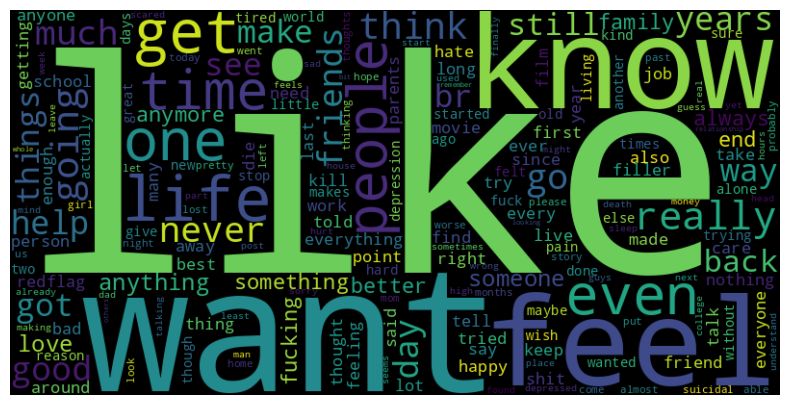

In [60]:
df_words = df.select(explode("filtered").alias("word"))

# Filter out common words or stop words if necessary
# You can use the 'stopwords' parameter in the WordCloud constructor

# Convert the DataFrame to Pandas for WordCloud generation
wordcloud_data = df_words.groupBy("word").count().toPandas()

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(wordcloud_data.set_index("word")["count"].to_dict())

# Display the WordCloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [61]:
def remove_empty_strings(array):
   return [x for x in array if x != '']

remove_empty_strings_udf = udf(remove_empty_strings, ArrayType(StringType()))

df = df.withColumn("lemmatized", remove_empty_strings_udf(df["lemmatized"]))

In [62]:
df.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|          lemmatized|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|[worried, , year,...|[worry, year, old...|
+--------------------+-----+--------------------+--------------------+--------------------+-----

In [63]:
hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=1000)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)

In [64]:
df.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|[dear, american, ...|(1000,[94,249,326...|(1000,[94,249,326...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|[nothing, look, f...|(1000,[53,115,133...|(1000,[53,115,133...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|

In [65]:
df = df.drop('tokened')
df = df.drop('filtered')
df = df.drop('lemmatized')
df = df.drop('extracted_text')

In [66]:
df.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+
|dear american tee...|    0|(1000,[94,249,326...|(1000,[94,249,326...|
|nothing look forw...|    1|(1000,[53,115,133...|(1000,[53,115,133...|
|music recommendat...|    0|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|(1000,[69,87,114,...|(1000,[69,87,114,...|
|worried  year old...|    1|(1000,[0,7,15,16,...|(1000,[0,7,15,16,...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [67]:
(train, test) = df.randomSplit([0.8,0.2], seed=2023)

In [68]:
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features')

In [69]:
# Hyperparameter Tuning

# Tuning maxIter
gb.setMaxIter(30)

# Tuning maxDepth
gb.setMaxDepth(8)

# Tuning maxBins
gb.setMaxBins(128)

# Tuning stepSize
gb.setStepSize(0.05)

# Tuning subsamplingRate
gb.setSubsamplingRate(0.8)

GBTClassifier_fbd5044f69ef

In [70]:
gbModel = gb.fit(train)

In [71]:
gb_predictions = gbModel.transform(test)

In [72]:
gb_predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  mg xanax thinki...|    1|(1000,[0,21,109,1...|(1000,[0,21,109,1...|[0.28799529532692...|[0.64014432043889...|       0.0|
| anything like  i...|    1|(1000,[0,17,34,43...|(1000,[0,17,34,43...|[-1.3281651436660...|[0.06559991594959...|       1.0|
| coins someone gi...|    0|(1000,[182,202,31...|(1000,[182,202,31...|[0.85673429359810...|[0.84728563488811...|       0.0|
| diagnosed depres...|    1|(1000,[3,7,9,15,3...|(1000,[3,7,9,15,3...|[-1.2547881343771...|[0.07518956879607...|       1.0|
| dying seems like...|    1|(1000,[7,55,64,65...|(1000,[7,55,64,65...|[-1.0508862023791...|[0.10892467215492...|       1.0|
+-------

In [73]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Accuracy:', multi_evaluator.evaluate(gb_predictions))

Accuracy: 0.8286073223259153


In [81]:
# create predict one
def predict_one(text):
    df_one = spark.createDataFrame([(text,)], ['text'])
    # remove symbols with regex
    df_one = df_one.withColumn('text', regexp_replace(col('text'), '[^\sa-zA-Z0-9]', ''))
    # lowercase
    df_one = df_one.withColumn('text', lower(col('text')))
    # extract text
    df_one = df_one.withColumn('extracted_text', extract_text_udf('text'))
    df_one = tokenizer.transform(df_one)
    df_one = stopwords_remover.transform(df_one)
    df_one = df_one.withColumn('lemmatized', lemmatize_udf(df_one['filtered']))
    df_one = hashingTF.transform(df_one)
    df_one = idfModel.transform(df_one)
    return gbModel.transform(df_one).collect()[0]['prediction']


In [85]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: i want to sleep because tomorrow is exam
The input suggests negative mental health


In [86]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: I've been feeling really hopeless, like nothing will ever get better, and I don't know how to change that.
The input suggests positive mental health.
